http://stackoverflow.com/questions/37508659/group-by-and-count-distinct-words-in-pandas-dataframe

http://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas


In [1]:
!ls -liLah ./share/Data/
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re


total 855M
6815808 drwxrwxr-x 2 marisa marisa 4.0K Dec 21 20:03 .
6815745 drwxr-xrwx 7 root   root   4.0K Dec 21 20:03 ..
6815810 -rw-r--r-- 1 marisa marisa 855M Dec 21 21:02 SPON_complete


In [2]:
# generate the raw_data from CSV
raw_data = pd.read_csv("./share/Data/SPON_complete", delimiter=",", skipinitialspace=True)

In [3]:
# Stopwords are downloaded and defined here
try:
    with open("german_stopwords_full.txt") as f:
        STOPWORDS = [line.strip() for line in f if not line.startswith(";")]
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/solariz/german_stopwords/master/german_stopwords_full.txt
    with open("german_stopwords_full.txt") as f:
        STOPWORDS = [line.strip() for line in f if not line.startswith(";")] 
      

SW = ["dass", "", " ", "worden", "jahren", "jahre", "jahr", "heißt", "heißen", "müsse", "prozent"]
_ = [STOPWORDS.append(w) for w in SW]

In [4]:
def count_words(source):
    """ Counting the words of the column article of a given Dataframe.
    
    It is possible to define a word, so only this word will be counted.
    """
    
    #split column Message to new df, create Serie by stack
    s = (source.article.str.split(expand=True).stack().str.lower()   )
    #remove multiindex
    s.index = s.index.droplevel(-1)
    s.name= 'words'
    #join Serie s to df source
    df = (source.join(s))
    
    # Cleaning the strings to be only alphanumeric
    df['words'] = df['words'].map(lambda x: re.sub(r'\W+', '', str(x)))
    
    df = df[~df['words'].isin(STOPWORDS)].groupby(['words']).size().reset_index(name='count').sort_values(by='count')
    
    return df


In [5]:
def wordcounter(source, word):
    df = count_words(source)
    return df[df['words'].str.contains(word)]

In [25]:
# This will generate a list of Strings, representating the months from .01.2001 to .12.2012
datestrings = [".{:02d}.20{:02d}".format(m,y)  for y in range(1, 17) for m in range(1, 13) ]

In [7]:
top25words = lambda m : count_words(
    raw_data
    [raw_data.day.str.contains(m, na=False)]
    ).nlargest(25, columns=['count', ]).set_index('words')

top25words_ofCategory = lambda m, c : count_words(
    raw_data[ 
        (raw_data.day.str.contains(m, na=False)) & (raw_data.cats.str.contains(c, na=False) )] 
    ).nlargest(25, columns=['count', ]).set_index('words')

# Count the absolute existence of one word
absolute_count = lambda d, w : wordcounter(raw_data
                                           [raw_data.day.str.contains(d, na=False)],word=w)['count'].sum()

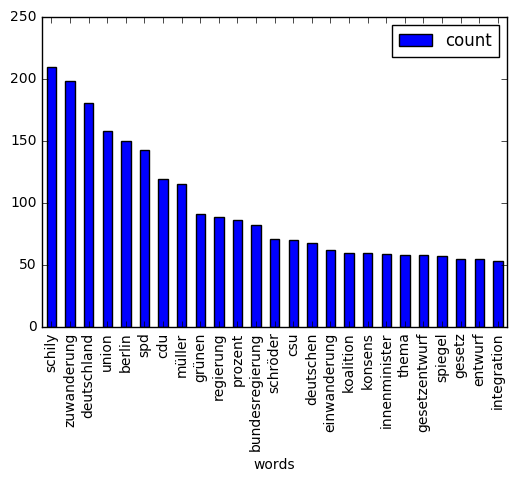

In [8]:
top25words_ofCategory('2001', 'politik').plot(kind="bar")

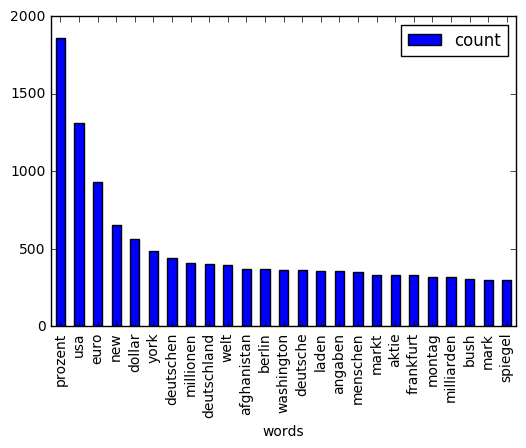

In [9]:
top25words('.09.2001').plot(kind="bar")

In [10]:
## TODO:
#   - Tabellenüberschrift mit gesuchtem Wort, sonst "words"
#   - konkatenieren von verschiedenen Suchbegriffen in einer 
#     großen Tabelle
#   - Schreiben der Daten in persistente Datenstruktur (CSV)

In [78]:
"""Testing"""
# t =[absolute_count(d, 'zuwanderung') for d in datestrings]
# d = pd.DataFrame(t)
# d.columns = ["zuwanderung"]
# d['zuwanderung_relativ'] = [v/d.zuwanderung.sum() for v in t]
# d.index = datestrings
# d.sort_values(by="zuwanderung")
# d.to_csv("./share/DATA/Spon_count_zuwanderung.csv" , sep=',')

d = pd.DataFrame.from_csv("./share/DATA/Spon_count_zuwanderung.csv" , sep=',')


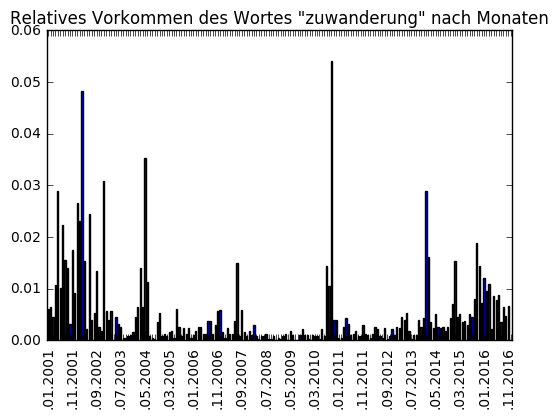

In [77]:
ax = d.zuwanderung_relativ.plot(
    kind='bar', 
    title='Relatives Vorkommen des Wortes "{}" nach Monaten'.format("zuwanderung"))

for label in ax.xaxis.get_ticklabels()[::1]:
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::10]:
    label.set_visible(True)    
